In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from statsmodels.stats import diagnostic
from scipy import stats
import os

In [2]:
# Import the pre-processed data
ratings_ba = pd.read_csv('Final/beer_advocate.csv', delimiter=',')
ratings_rb = pd.read_csv('Final/rate_beer.csv', delimiter=',')

### 1. Deal with NaN values

Some columns may contain NaN values.<br>
We will look at the data to see which one are concerned and what to do with them.

In [3]:
# Check nan values
def nan_ratio(ratings):
    float_columns = list()
    for column in ratings.columns:
        if ratings[column].dtype == float:
            float_columns.append(column)

    N = ratings.shape[0]
    nan_ratio = list()
    for column in float_columns:
        col = ratings[column]
        nb_nan = 0
        for elem in col:
            if not np.isfinite(elem):
                nb_nan+=1
        nan_ratio.append(nb_nan/N)
    return float_columns, nan_ratio

In [4]:
float_columns_ba, nan_ratio_ba = nan_ratio(ratings_ba)
float_columns_rb, nan_ratio_rb = nan_ratio(ratings_rb)

In [5]:
print(" --- BeerAdvocate ---")
for col, nan in zip(float_columns_ba, nan_ratio_ba):
    print("Column {:s} has a NaN ratio of {:.2f}%".format(col, nan*100))
    
print("\n --- RateBeer ---")
for col, nan in zip(float_columns_rb, nan_ratio_rb):
    print("Column {:s} has a NaN ratio of {:.2f}%".format(col, nan*100))

 --- BeerAdvocate ---
Column avg has a NaN ratio of 0.00%
Column ba_score has a NaN ratio of 0.00%
Column bros_score has a NaN ratio of 76.44%
Column abv has a NaN ratio of 1.38%
Column avg_computed has a NaN ratio of 0.00%
Column zscore has a NaN ratio of 87.43%
Column avg_matched_valid_ratings has a NaN ratio of 87.43%

 --- RateBeer ---
Column overall_score has a NaN ratio of 0.25%
Column style_score has a NaN ratio of 0.01%
Column avg has a NaN ratio of 0.00%
Column abv has a NaN ratio of 0.83%
Column avg_computed has a NaN ratio of 0.00%
Column zscore has a NaN ratio of 82.63%
Column avg_matched_valid_ratings has a NaN ratio of 82.63%


We can see that zscore and avg_matched_valid_ratings contain more than 80% of Nan values in both datasets.
And in *BeerAdvocate* dataset the bros_score has more than 75% of Nan values.

As those features only have a few values which ill therefore be difficult to interpret we should get rid of them.

In [6]:
columns_to_delete_ba = ['bros_score', 'zscore', 'avg_matched_valid_ratings']
columns_to_delete_rb = ['zscore', 'avg_matched_valid_ratings']

ratings_ba = ratings_ba.drop(columns_to_delete_ba, axis=1)
ratings_rb = ratings_rb.drop(columns_to_delete_rb, axis=1)

For the other features which only contains a few NaN values we can replace them by the median

In [7]:
def replace_nan_with_median(ratings, float_columns, delete_columns):
    res = ratings
    for col in float_columns:
        if col not in delete_columns:
            median = np.nanmedian(res[col])
            res[col].fillna(median, inplace=True)

In [8]:
replace_nan_with_median(ratings_ba, float_columns_ba, columns_to_delete_ba)
replace_nan_with_median(ratings_rb, float_columns_rb, columns_to_delete_rb)

In [9]:
# Make sure all nan value are gone
print(nan_ratio(ratings_ba))
print(nan_ratio(ratings_rb))

(['avg', 'ba_score', 'abv', 'avg_computed'], [0.0, 0.0, 0.0, 0.0])
(['overall_score', 'style_score', 'avg', 'abv', 'avg_computed'], [0.0, 0.0, 0.0, 0.0, 0.0])


All float columns do not contain NaN values anymore

### 2. Most important breweries

We will now take a look at the most important breweries. Those are the one that we are going to be able to advice.

In [10]:
# Import breweries data
breweries_rb = pd.read_csv("data/RateBeer/breweries.csv", delimiter=',')
breweries_ba = pd.read_csv("data/BeerAdvocate/breweries.csv", delimiter=',')

In [11]:
breweries_rb.head()

,id,location,name,nbr_beers
0,3198,Gabon,Sobraga,3
1,13538,Northern Ireland,Ards Brewing Co.,13
2,22304,Northern Ireland,Barrahooley Craft Brewery,4
3,22818,Northern Ireland,Boundary,66
4,24297,Northern Ireland,Brewbot Belfast,3


In [12]:
breweries_ba.head()

,id,location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4
4,39916,Kyrgyzstan,Kellers Bier,2


In both datasets breweries have the same columns

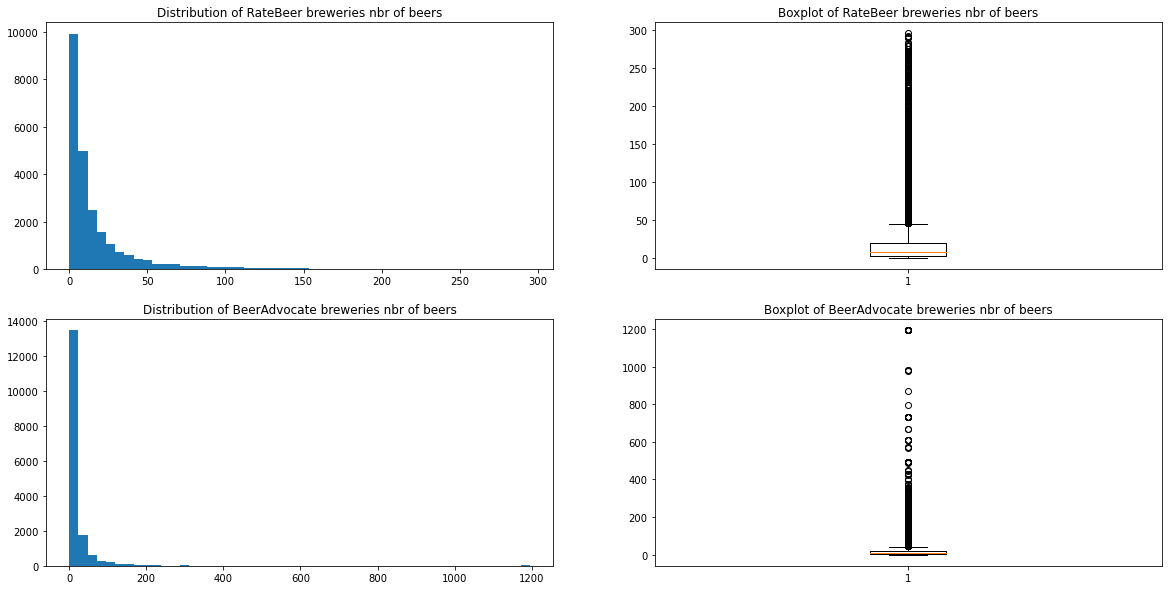

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# Histogram of RateBeer breweries nbr of beers
subplot = axs[0, 0]
subplot.hist(breweries_rb['nbr_beers'], bins=50)
subplot.set_title('Distribution of RateBeer breweries nbr of beers')

# Boxplot of RateBeer breweries nbr of beers
subplot = axs[0, 1]
subplot.boxplot(breweries_rb['nbr_beers'])
subplot.set_title('Boxplot of RateBeer breweries nbr of beers')

# Distribution of BeerAdvocate breweries nbr of beers
subplot = axs[1, 0]
subplot.hist(breweries_ba['nbr_beers'], bins=50)
subplot.set_title('Distribution of BeerAdvocate breweries nbr of beers')

# Boxplot of BeerAdvocate breweries nbr of beers
subplot = axs[1, 1]
subplot.boxplot(breweries_ba['nbr_beers'])
subplot.set_title('Boxplot of BeerAdvocate breweries nbr of beers')

plt.show()

We can see that *BeerAdvocate* has breweries that contain up to 1200 beers. But in both datasets, the majority of breweries only sell a few beers.

In [14]:
# First which breweries sell the most beers
def top_k_breweries(breweries_df, k):
    nbr_breweries = breweries_df.shape[0]
    index_sorted = np.argsort(breweries_df['nbr_beers'])
    return breweries_df.iloc[index_sorted[nbr_breweries-k:]]

In [15]:
# Test : top 10 breweries in RateBeer
top_k_breweries(breweries_rb, 10)

,id,location,name,nbr_beers
20942,3911,England,Brodies Beers,279
13846,340,"United States, California",Karl Strauss Brewing Company,280
18191,14870,"United States, Florida",Proof Brewing Company,282
21861,4443,England,Thornbridge,283
19411,489,"United States, Connecticut",Willimantic Brewing Company,283
13644,17792,"United States, California",Cellarmaker Brewing Company,289
16961,13326,"United States, Missouri",Perennial Artisan Ales,290
21426,2292,England,Rudgate,290
14870,14248,"United States, Massachusetts",Night Shift Brewing,291
12494,20106,Poland,Browar Wąsosz,295


In [16]:
top_100_breweries_rb = top_k_breweries(breweries_rb, 100)
top_100_breweries_ba = top_k_breweries(breweries_ba, 100)

In [23]:
# Then we can select the breweries that have the most ratings
def total_nbr_ratings(breweries_df, ratings_df):
    nbr_ratings_list = list()
    for brewery_id in breweries_df['id']:
        nbr_ratings_list.append(sum(ratings_df[ratings_df['brewery_id'] == brewery_id].nbr_ratings))
    return nbr_ratings_list

In [24]:
breweries_rb['total_nbr_ratings'] = total_nbr_ratings(breweries_rb, ratings_rb)
breweries_ba['total_nbr_ratings'] = total_nbr_ratings(breweries_ba, ratings_ba)

In [25]:
breweries_rb.head()

,id,location,name,nbr_beers,total_nbr_ratings
0,3198,Gabon,Sobraga,3,0
1,13538,Northern Ireland,Ards Brewing Co.,13,0
2,22304,Northern Ireland,Barrahooley Craft Brewery,4,0
3,22818,Northern Ireland,Boundary,66,0
4,24297,Northern Ireland,Brewbot Belfast,3,0


It seems that some breweries are not rated, let's check out how many

In [35]:
index_not_rated_breweries = np.where(breweries_rb['total_nbr_ratings'] == 0)
N = breweries_rb.shape[0]
ratio_not_rated_rb = len(index_not_rated_breweries[0]) / N
print("In RateBeer {:.2f}% of breweries are not rated".format(ratio_not_rated_rb*100))

index_not_rated_breweries = np.where(breweries_ba['total_nbr_ratings'] == 0)
N = breweries_ba.shape[0]
ratio_not_rated_ba = len(index_not_rated_breweries[0]) / N
print("In BeerAdvocate {:.2f}% of breweries are not rated".format(ratio_not_rated_ba*100))

In RateBeer 96.98% of breweries are not rated
In BeerAdvocate 97.28% of breweries are not rated


We can see here that most breweries are not rated therefore those breweries won't be useful to analyze.<br>
Now we can then see which are the most popular breweries, which are the one obtaining most ratings.

In [36]:
def top_k_rated_breweries(breweries_df, k):
    nbr_breweries = breweries_df.shape[0]
    index_sorted = np.argsort(breweries_df['total_nbr_ratings'])
    return breweries_df.iloc[index_sorted[nbr_breweries-k:]]

In [41]:
# Test : top 10 breweries in RateBeer
top_k_rated_breweries(breweries_rb, 10)

,id,location,name,nbr_beers,total_nbr_ratings
13189,75,"United States, Wisconsin",Miller Brewing Company &#40;MillerCoors&#41;,194,28250
15085,90,"United States, New York",Brooklyn Brewery,179,28525
15841,109,"United States, Maryland",Flying Dog Brewery,225,29998
15566,292,"United States, Colorado",Great Divide Brewing Company,176,31341
15323,3473,"United States, New York",Southern Tier Brewing Company &#40;ABV&#41;,147,33607
19738,12853,"United States, Illinois",Goose Island Beer Company &#40;AB-InBev&#41;,263,34095
14011,7043,"United States, California",Port Brewing Company / The Lost Abbey,219,37579
13864,1167,"United States, California",Lagunitas Brewing Company &#40;Heineken&#41;,234,38783
16902,84,"United States, Missouri",Anheuser-Busch InBev,216,44951
19227,96,"United States, Oregon",Rogue Ales,218,51804


In [37]:
top_100_rated_breweries_rb = top_k_rated_breweries(breweries_rb, 100)
top_100_rated_breweries_ba = top_k_rated_breweries(breweries_ba, 100)

In [50]:
# Plot the average number of beers for both top k methods
def avg_nbr_beers(breweries_df, k_min=10, k_max=200, k_step=10):
    avg_method1 = list()
    avg_method2 = list()
    k_values = list()

    for k in range(k_min, k_max, k_step):
        top_k1 = top_k_breweries(breweries_df, k)
        top_k2 = top_k_rated_breweries(breweries_df, k)

        avg1 = top_k1['nbr_beers'].mean()
        avg2 = top_k2['nbr_beers'].mean()

        avg_method1.append(avg1)
        avg_method2.append(avg2)
        k_values.append(k)
        
    return k_values, avg_method1, avg_method2

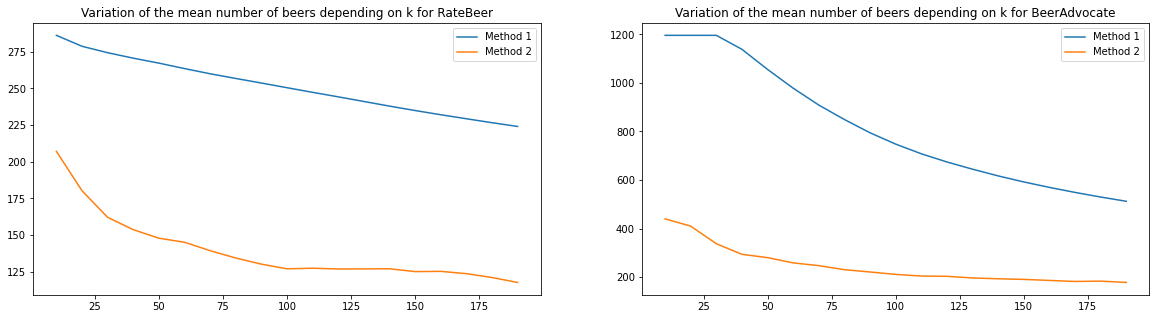

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Variation of the mean number of beers depending on k for RateBeer
subplot = axs[0]
k_values, avg_method1, avg_method2 = avg_nbr_beers(breweries_rb)
subplot.plot(k_values, avg_method1, label='Method 1')
subplot.plot(k_values, avg_method2, label='Method 2')
subplot.legend()
subplot.set_title('Variation of the mean number of beers depending on k for RateBeer')

# Variation of the mean number of beers depending on k for BeerAdvocate
subplot = axs[1]
k_values, avg_method1, avg_method2 = avg_nbr_beers(breweries_ba)
subplot.plot(k_values, avg_method1, label='Method 1')
subplot.plot(k_values, avg_method2, label='Method 2')
subplot.legend()
subplot.set_title('Variation of the mean number of beers depending on k for BeerAdvocate')

plt.show()

From those graphs we can see that in both datasets the method 1 as a higher mean value for the number of beers which means that the breweries with the most beers are not the one with the most ratings. Moreover, with the method 2 the breweries selected still sell many beers and will therefore still be interesting to advice.

In conclusion we will use the second method to determine the top beers.